In [1]:
import pandas as pd
import glob
import os
from __future__ import division
from datetime import datetime
import pickle
from PIL import Image
from VAMPIRE_backend import cntarea,cntAR,cntExtent,cntEquiDia,cntsol,bdreg,pca_bdreg,clusterSM,update_csv
from time import time

In [2]:
N=10 #equidistant points along cell boundary
clnum = 10
modelname='testmodel'
outpth = r'C:\Users\kyuha\PycharmProjects\VAMPIRE_open\Source Code Contour\new code'

In [3]:
modelpth = r'C:\Users\kyuha\PycharmProjects\VAMPIRE_open\Source Code Contour\new code\testmodel\testmodel.pickle'
tilepth = r'\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE'
setpaths = glob.glob(os.path.join(tilepth,'*'))
setID = [os.path.basename(_).split('_')[1] for _ in setpaths] #patient id
condition = [os.path.basename(_).split('_')[3] for _ in setpaths] #section id
setpaths = [os.path.join(*[_,'out','json']) for _ in setpaths]
setpaths2 = setpaths[0:1]

In [4]:
def cellclass(cnt):
    celltype = dlim.getpixel((round(cnt[0]),round(cnt[1])))
    return celltype

In [ ]:
# jsnucs = pd.DataFrame()
for setidx, setpath in enumerate(setpaths):
    # patientdir = r'\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_8_sec_1'
    # jsondir = os.path.join(*[patientdir,'out','json'])
    start = time()
    jsondir = setpath
    if os.path.exists(os.path.join(jsondir,'boundary.pkl')):continue
    jsons = glob.glob(os.path.join(jsondir,'*json'))
    dldir = os.path.dirname(os.path.dirname(jsondir)).replace('TILE','DLTILE')
    # dls = glob.glob(os.path.join(dldir,'*tif'))
    jsnucs = pd.DataFrame()
    if len(jsons)==0:continue
    for js in jsons:
        jss = pd.read_json(js)
        imid = os.path.splitext(os.path.basename(js))[0]
        dl = os.path.join(dldir,imid+'.tif')
        dlim = Image.open(dl)
        jsnuc = jss['nuc'].apply(pd.Series)
        if len(jsnuc)==0:continue
        jsnuc = jsnuc.drop(['type_prob'], axis=1).reset_index(drop=True)
        jsnuc['celltype'] = jsnuc['centroid'].apply(lambda row: cellclass(row))
        jsnucs = pd.concat([jsnucs,jsnuc],ignore_index=True)
    jsnucs = jsnucs[jsnucs['contour'].map(len) > 5]
    jsnucs.to_pickle(os.path.join(jsondir,'boundary.pkl'))
    print(os.path.join(jsondir,'boundary.pkl'))
    print(setidx,round(time()-start),'seconds')

\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_320_sec_4\out\json\boundary.pkl
288 8 seconds
\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_321_sec_1\out\json\boundary.pkl
289 33 seconds
\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_321_sec_2\out\json\boundary.pkl
290 18 seconds
\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_329-duplicate_sec_1\out\json\boundary.pkl
291 18 seconds
\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_329-duplicate_sec_2\out\json\boundary.pkl
292 15 seconds
\\motherserverdw\Kyu_Sync\Research\Database\Hamamatsu Nanozoomer Temporary Repository\IMCROP20x\IMCROP_processed\TILE\imID_329_sec_

KeyboardInterrupt: 

In [45]:
start = time()
pkls = pd.DataFrame()
for setidx, setpath in enumerate(setpaths[0:50]):
    start = time()
    pkl = pd.read_pickle(os.path.join(setpath,'boundary.pkl'))
    pkls = pd.concat([pkls,pkl],ignore_index=True)
print(round(time()-start),'seconds')

0 seconds


In [51]:
start = time()
pkls = pkls[pkls['contour'].map(len) > 5] # need at least 5 points to quantify morphology
pkls['Area'] = pkls['contour'].apply(lambda row: cntarea(row))
pkls['AR'] = pkls['contour'].apply(lambda row: cntAR(row))
pkls['Sol'] = pkls['contour'].apply(lambda row: cntExtent(row))
pkls['Extent'] = pkls['contour'].apply(lambda row: cntEquiDia(row))
pkls['EquiDia'] = pkls['contour'].apply(lambda row: cntsol(row))
pkls = pkls.drop(['bbox','centroid','contour','type'], axis=1)
print(round(time()-start),'seconds')
pkls

C:\Users\kyuha\AppData\Local\Temp/ipykernel_33076/67631967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pkls['AR'] = pkls['contour'].apply(lambda row: cntAR(row))
C:\Users\kyuha\AppData\Local\Temp/ipykernel_33076/67631967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pkls['Sol'] = pkls['contour'].apply(lambda row: cntExtent(row))
C:\Users\kyuha\AppData\Local\Temp/ipykernel_33076/67631967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

26 seconds


C:\Users\kyuha\AppData\Local\Temp/ipykernel_33076/67631967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pkls['EquiDia'] = pkls['contour'].apply(lambda row: cntsol(row))


,bbox,centroid,contour,type,celltype,AR,Sol,Extent,EquiDia
0,"[[965, 965], [981, 987]]","[975.4083969465648, 972.3931297709923]","[[973, 965], [972, 966], [971, 966], [970, 967...",None,2,0.706808,0.669034,17.316117,0.961224
1,"[[957, 881], [999, 948]]","[911.4903100775193, 976.8914728682171]","[[944, 957], [943, 958], [940, 958], [939, 959...",None,2,0.162669,0.156894,23.709392,0.676628
2,"[[982, 954], [996, 971]]","[961.8663101604278, 988.4652406417113]","[[960, 982], [959, 983], [958, 983], [957, 984...",None,2,0.789848,0.691176,14.472315,0.967647
3,"[[0, 932], [9, 947]]","[938.7142857142857, 3.789915966386554]","[[933, 0], [933, 1], [932, 2], [932, 6], [934,...",None,2,0.759950,0.737037,11.255547,0.975490
4,"[[30, 927], [40, 942]]","[934.1008403361344, 35.016806722689076]","[[933, 30], [932, 31], [930, 31], [927, 34], [...",None,2,0.646366,0.670000,11.311966,0.957143
...,...,...,...,...,...,...,...,...,...
826413,"[[194, 477], [205, 487]]","[481.88461538461536, 199.0897435897436]","[[481, 194], [481, 195], [477, 199], [477, 200...",None,10,0.793498,0.581818,9.027033,0.948148
826414,"[[211, 573], [221, 581]]","[576.5737704918033, 215.2295081967213]","[[574, 211], [574, 212], [573, 213], [573, 215...",None,10,0.752132,0.593750,7.776817,0.896226
826415,"[[220, 336], [236, 347]]","[341.10526315789474, 226.99122807017545]","[[338, 220], [336, 222], [337, 223], [337, 225...",None,10,0.515799,0.539773,10.998080,0.875576
826416,"[[259, 164], [270, 174]]","[168.22368421052633, 263.7894736842105]","[[167, 259], [166, 260], [165, 260], [165, 261...",None,10,0.914510,0.563636,8.884866,0.939394


0 seconds


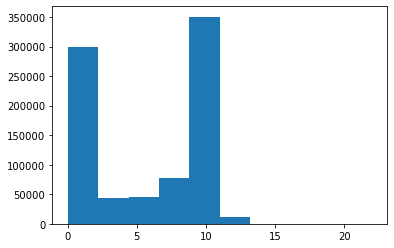

In [47]:
from matplotlib import pyplot as plt
start = time()
plt.hist(pkls['celltype'])
print(round(time()-start),'seconds')

In [48]:
bd1 = pkls[pkls['celltype']==1]

,bbox,centroid,contour,type,celltype
186,"[[792, 689], [804, 697]]","[692.1428571428571, 797.8571428571429]","[[694, 792], [692, 794], [691, 794], [690, 795...",None,1
441,"[[166, 515], [178, 614]]","[554.4595660749507, 171.17554240631165]","[[521, 166], [520, 167], [517, 167], [516, 168...",None,1
471,"[[349, 382], [369, 392]]","[386.568345323741, 358.40287769784175]","[[385, 349], [384, 350], [384, 351], [383, 352...",None,1
604,"[[486, 63], [504, 71]]","[66.35, 494.42]","[[68, 486], [66, 488], [65, 488], [64, 489], [...",None,1
763,"[[237, 750], [288, 864]]","[803.768094534712, 258.4992614475628]","[[751, 237], [750, 238], [753, 238], [754, 239...",None,1
...,...,...,...,...,...
824895,"[[915, 446], [930, 461]]","[451.9313725490196, 923.0098039215686]","[[447, 915], [446, 916], [446, 921], [449, 924...",None,1
824908,"[[928, 455], [953, 483]]","[465.8, 939.7225806451613]","[[459, 928], [458, 929], [456, 929], [455, 930...",None,1
825166,"[[58, 526], [72, 545]]","[535.1515151515151, 65.29292929292929]","[[527, 58], [526, 59], [527, 60], [527, 61], [...",None,1
825231,"[[445, 708], [458, 758]]","[734.8089552238806, 451.20298507462684]","[[753, 445], [752, 446], [750, 446], [749, 447...",None,1


In [ ]:
VamModel = {
            "N": [],
            "bdrn": [],
            "mdd": [],
            "pc": [],
            "clnum": [],
            "pcnum": [],
            "mincms": [],
            "testmean": [],
            "teststd": [],
            "boxcoxlambda": [],
            "C": [],
            "Z": []
        }

build_model = True
B = bd1['contour']
bdpc, VamModel = bdreg(B, N, VamModel, build_model)
score, VamModel = pca_bdreg(bdpc, VamModel, True)
pcnum = None # none is 20 by default
IDX, IDX_dist, VamModel, goodness = clusterSM(outpth, score, bdpc, clnum, pcnum, VamModel, True, None, None,modelname)

In [ ]:
if os.path.exists(os.path.join(*[outpth, modelname, modelname+'.pickle'])):
    realtimedate = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    f = open(os.path.join(*[outpth, modelname, modelname+'_'+realtimedate+'.pickle']), 'wb')
else:
    f = open(os.path.join(*[outpth, modelname, modelname+'.pickle']), 'wb')
pickle.dump(VamModel, f)
f.close()

In [ ]:
experimental = False
tag = ['corneum','spinosum','hairshaft','hairfollicle','smoothmuscle']

In [ ]:
try:
    f = open(modelpth, 'rb')
except:
    print('the model does not exist. please replace model name to the one you built')
vampire_model = pickle.load(f)
N = vampire_model['N']
clnum = vampire_model['clnum']
pcnum = vampire_model['pcnum']

In [ ]:
for setidx, setpath in enumerate(setpaths2):
    pkl = pd.read_pickle(os.path.join(setpath,'boundary.pkl'))
    pkl['AR'] = pkl['contour'].apply(lambda row: cntAR(row))
    pkl['Sol'] = pkl['contour'].apply(lambda row: cntExtent(row))
    pkl['Extent'] = pkl['contour'].apply(lambda row: cntEquiDia(row))
    pkl['EquiDia'] = pkl['contour'].apply(lambda row: cntsol(row))
    pkl = pkl.drop(['bbox','centroid','contour','type'], axis=1)
    B = pkl['contour']

    bdpc, vampire_model = bdreg(B, N, vampire_model, build_model)
    score, vampire_model = pca_bdreg(bdpc, vampire_model, build_model)
    IDX, IDX_dist, VamModel, goodness = clusterSM(outpth, score, bdpc, clnum, pcnum, vampire_model, False, condition[setidx], setID[setidx],modelname)

    datasheet = 'VAMPIRE datasheet ' + tag + '.csv'
    goodness = goodness.transpose()
    pkl['Shape mode']= pd.Series(IDX)
    pkl['Distance from cluster center'] = pd.Series(IDX_dist)
    for idx,column in enumerate(goodness):
        pkl['probability of shape mode '+str(idx)] = column
    pkl.to_csv(os.path.join(setpath, datasheet), index=False)

In [ ]:
# update_csv(IDX, IDX_dist, tag[setidx], setpath, goodness=goodness)